In [1]:
import pandas as pd
from pandas.core.series import Series
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import mapply
mapply.init(n_workers=7, progressbar=True)


# Read the data
INCIDENTS = '../dataset/data-raw/incidents.csv'
POVERTYYEAY = '../dataset/data-raw/povertyByStateYear.csv'
STATEDISHOUSE = '../dataset/data-raw/year_state_district_house.csv'
POPULATION = '../dataset/data-raw/population.csv'

incidents = pd.read_csv(INCIDENTS)
poverty = pd.read_csv(POVERTYYEAY)
state_district_house = pd.read_csv(STATEDISHOUSE)
population = pd.read_csv(POPULATION, index_col=0)

incidents['state'] = incidents['state'].str.upper()
poverty['state'] = poverty['state'].str.upper()
state_district_house['state'] = state_district_house['state'].str.upper()

incidents['date_year'] = incidents['date'].str.split('-').str[0].astype(int)
incidents['date_month'] = incidents['date'].str.split('-').str[1].astype(int)
incidents['date_day'] = incidents['date'].str.split('-').str[2].astype(int)
del incidents['date']

population['NAME'] = population['NAME'].str.upper()

incidents = incidents[['date_year', 'date_month', 'date_day', 'state', 'city_or_county', 'latitude', 'longitude', 'congressional_district', 'min_age_participants', 'avg_age_participants', 'max_age_participants', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed', 'n_participants', 'incident_characteristics1']].copy()


/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4381/1020365938.py:16: DtypeWarning: Columns (15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.read_csv(INCIDENTS)


In [2]:
population.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 5 to 55
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NAME               50 non-null     object
 1   CENSUS2010POP      50 non-null     int64 
 2   ESTIMATESBASE2010  50 non-null     int64 
 3   POPESTIMATE2010    50 non-null     int64 
 4   POPESTIMATE2011    50 non-null     int64 
 5   POPESTIMATE2012    50 non-null     int64 
 6   POPESTIMATE2013    50 non-null     int64 
 7   POPESTIMATE2014    50 non-null     int64 
 8   POPESTIMATE2015    50 non-null     int64 
 9   POPESTIMATE2016    50 non-null     int64 
 10  POPESTIMATE2017    50 non-null     int64 
 11  POPESTIMATE2018    50 non-null     int64 
 12  POPESTIMATE2019    50 non-null     int64 
dtypes: int64(12), object(1)
memory usage: 5.5+ KB


In [3]:
population.head()

,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019
5,ALABAMA,4779736,4780125,4785437,4799069,4815588,4830081,4841799,4852347,4863525,4874486,4887681,4903185
6,ALASKA,710231,710249,713910,722128,730443,737068,736283,737498,741456,739700,735139,731545
7,ARIZONA,6392017,6392288,6407172,6472643,6554978,6632764,6730413,6829676,6941072,7044008,7158024,7278717
8,ARKANSAS,2915918,2916031,2921964,2940667,2952164,2959400,2967392,2978048,2989918,3001345,3009733,3017804
9,CALIFORNIA,37253956,37254519,37319502,37638369,37948800,38260787,38596972,38918045,39167117,39358497,39461588,39512223


In [4]:
population_clean = population.copy()
population_clean = population_clean.drop(columns=['CENSUS2010POP', 'ESTIMATESBASE2010'])
population_clean.columns = population_clean.columns.str.removeprefix('POPESTIMATE')
# given columns like 2010, 2011, ... 2019, we want to have a column year and a column population
population_clean = population_clean.melt(id_vars=['NAME'], var_name='YEAR', value_name='state_population')
population_clean["YEAR"] = population_clean["YEAR"].astype(int)

In [5]:
population_clean.head()

,NAME,YEAR,state_population
0,ALABAMA,2010,4785437
1,ALASKA,2010,713910
2,ARIZONA,2010,6407172
3,ARKANSAS,2010,2921964
4,CALIFORNIA,2010,37319502


In [6]:
population_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   NAME              500 non-null    object
 1   YEAR              500 non-null    int64 
 2   state_population  500 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.8+ KB


In [7]:
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_year                  239677 non-null  int64  
 1   date_month                 239677 non-null  int64  
 2   date_day                   239677 non-null  int64  
 3   state                      239677 non-null  object 
 4   city_or_county             239677 non-null  object 
 5   latitude                   231754 non-null  float64
 6   longitude                  231754 non-null  float64
 7   congressional_district     227733 non-null  float64
 8   min_age_participants       164879 non-null  object 
 9   avg_age_participants       165057 non-null  object 
 10  max_age_participants       164969 non-null  object 
 11  n_participants_child       197573 non-null  object 
 12  n_participants_teen        197578 non-null  object 
 13  n_participants_adult       19

In [8]:
incidents['incident_characteristics1'].head()

0                       Shot - Wounded/Injured
1    Shot - Dead (murder, accidental, suicide)
2                       Shot - Wounded/Injured
3                       Shot - Wounded/Injured
4                       Shot - Wounded/Injured
Name: incident_characteristics1, dtype: object

In [9]:
incidents['incident_characteristics1'].unique() #?

charateristics_translate = { #why here?
    'Shot - Wounded/Injured': 'SHOT_INJURED',
    'Shot - Dead (murder, accidental, suicide)': 'SHOT_DEAD',
    'Institution/Group/Business': 'INSTITUTION',
    'Shots Fired - No Injuries': 'SHOTS_FIRED_UNHARMED',
    'Non-Shooting Incident': 'NON_SHOOTING',
    'Armed robbery with injury/death and/or evidence of DGU found': 'ARMED_ROBBERY',
    'Defensive Use': 'DEFENSIVE_USE',
    'Shots fired, no action (reported, no evidence found)': 'SHOTS_FIRED_UNCONCLUSIVE',
    'TSA Action': 'TSA_ACTION',
    'Gun(s) stolen from owner': 'STOLEN_GUN',
    'Brandishing/flourishing/open carry/lost/found': 'MISC',
    'Accidental Shooting': 'SHOTS_ACCIDENTAL',
    'Possession (gun(s) found during commission of other crimes)': 'UNEXPECTED_GUN',
    'Domestic Violence': 'DOMESTIC_VIOLENCE',
    'Car-jacking': 'CAR_JACKING',
    'Drug involvement': 'DRUG_INVOLVEMENT',
    'Attempted Murder/Suicide (one variable unsuccessful)': 'ATTEMPTED_MURDER-SUICIDE',
    'Home Invasion': 'HOME_INVASION',
    'Pistol-whipping': 'PISTOL_WHIPPING',
    'Officer Involved Incident': 'OFFICER_INVOLVED',
    'ATF/LE Confiscation/Raid/Arrest': 'ATL-LE_CONFISCATION',
    'Suicide - Attempt': 'SUICIDE_ATTEMPT',
    'Kidnapping/abductions/hostage': 'KIDNAPPING',
    'Possession of gun by felon or prohibited person': 'FELON_POSSESSION',
    'Gang involvement': 'GANG_INVOLVEMENT',
    'Murder/Suicide': 'MURDER-SUICIDE',
    'Animal shot/killed': 'SHOT_KILLED_ANIMAL',
    'Bar/club incident - in or around establishment': 'BAR-CLUB_INCIDENT',
    'Sex crime involving firearm': 'SEX_CRIME_WITH_FIREARM',
    'School Incident': 'SCHOOL',
    'Non-Aggression Incident': 'NON_AGGRESSION',
    'Drive-by (car to street, car to car)': 'DRIVE_BY',
    'Gun buy back action': 'GUN_BUY_BACK',
    'Gun shop robbery or burglary': 'GUN_SHOP_ROBBERY',
    'Stolen/Illegally owned gun{s} recovered during arrest/warrant': 'ILLEGAL_GUN_RECOVERY',
    'Guns stolen from law enforcement': 'GUNS_STOLEN_FROM_LE',
    'Suicide^': 'SUICIDE',
    'Implied Weapon': 'IMPLIED_WEAPON',
    'Criminal act with stolen gun': 'CRIMINAL_ACT_WITH_STOLEN_GUN',
    'Gun at school, no death/injury - elementary/secondary school': 'SCHOOL_GUN_POSSESSION',
    'Road rage': 'ROAD_RAGE',
    'BB/Pellet/Replica gun': 'FAKE_GUN',
    'LOCKDOWN/ALERT ONLY: No GV Incident Occurred Onsite': 'LOCKDOWN_ALERT_ONLY',
    'Mass Shooting (4+ victims injured or killed excluding the subject/suspect/perpetrator, one location)': 'MASS_SHOOTING',
    'House party': 'HOUSE_PARTY',
    'ShotSpotter': 'SHOT_SPOTTER',
    'Child Involved Incident': 'CHILD_INVOLVED_INCIDENT',
    'Under the influence of alcohol or drugs (only applies to the subject/suspect/perpetrator )': 'UNDER_INFLUENCE',
    'Spree Shooting (multiple victims, multiple locations)': 'SPREE_SHOOTING',
    'Hate crime': 'HATE_CRIME',
    'Unlawful purchase/sale': 'UNLAWFUL_PURCHASE_SALE',
    'Gun range/gun shop/gun show shooting': 'GUN_SHOP_SHOOTING',
}

In [10]:
# set non-numeric values to NaN in columns supposed to be numeric

objcols = incidents.select_dtypes(include=['object']).columns
objcols = objcols.drop(['state', 'city_or_county', 'incident_characteristics1'])

for col in objcols:
    incidents[col] = incidents[col].mapply(pd.to_numeric, errors='coerce')

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 70.47it/s]
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 69.30it/s]
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 66.47it/s]
/home/simone/Unipi/InProgress/DM/DataMining-20

In [11]:
# Input: A row of the dataframe
# Effect: Infer the congressional district when missing as the most common one in the row's state_city
# Return: The modified row with the inferred congrational district
def find_congrational_district(row): #? not used
    # fix the pair [state, city_or_county]
    df = incidents[(incidents['state'] == row['state']) * (incidents['city_or_county'] == row['city_or_county'])]
    # find the most common congressional district:
    # for each congrational district counting the occurrences
    val_counts = df['congressional_district'].value_counts()
    # if no congrational_district value is found for the pair [state, city_or_county], set the congressional_district to NaN
    if val_counts.empty:
        row['congressional_district'] = np.nan
        return row
    # else set the congressional_district with the most common congressional_district value
    inferred_congrational_district = val_counts.idxmax()
    row['congressional_district'] = inferred_congrational_district
    return row

# Input: A row of the dataframe
# Effect: Set out-of-sensible range values to NaN
# Return: The modified row obtained substituting values out of the correct ranges with NaN
def sensibleValues(row):
    # --- range checks ---
    if row['date_year'] > 2020:
        row['date_year'] = np.nan
    if row['min_age_participants'] > 110 or row['min_age_participants'] < 0:
        row['min_age_participants'] = np.nan
    if row['avg_age_participants'] > 110 or row['avg_age_participants'] < 0:
        row['avg_age_participants'] = np.nan
    if row['max_age_participants'] > 110 or row['max_age_participants'] < 0:
        row['max_age_participants'] = np.nan
    # 103 is the maximum value of n_participants
    if row['n_participants_child'] > 103 or row['n_participants_child'] < 0:
        row['n_participants_child'] = np.nan
    if row['n_participants_teen'] > 103 or row['n_participants_teen'] < 0:
        row['n_participants_teen'] = np.nan
    if row['n_participants_adult'] > 103 or row['n_participants_adult'] < 0:
        row['n_participants_adult'] = np.nan
    if row['n_killed'] > 103 or row['n_killed'] < 0:
        row['n_killed'] = np.nan
    if row['n_injured'] > 103 or row['n_injured'] < 0:
        row['n_injured'] = np.nan
    if row['n_arrested'] > 103 or row['n_arrested'] < 0:
        row['n_arrested'] = np.nan
    if row['n_unharmed'] > 103 or row['n_unharmed'] < 0:
        row['n_unharmed'] = np.nan
    return row

# The new incidents dataframe after applying sensibleValues function:
sincidents = incidents.mapply(sensibleValues, axis=1)

# Create a new column 'state_city' that unify 'state' and 'city_or_county' columns
sincidents['state_city'] = sincidents['state'] + "-" + sincidents['city_or_county']

# Take the subtable made by 'state_city' and 'congressional_district' columns
congrational_districts_df = sincidents[['state_city', 'congressional_district']]

# Group by state_city and, for each state_city, count the occurrences of each congressional_district
congrational_districts_val_counts = congrational_districts_df.groupby('state_city')['congressional_district'].value_counts()

# Reset the index of the Series obtained in the previous step, converting it to a DataFrame; the counts are stored in a column named 'count'
congrational_districts_val_counts = congrational_districts_val_counts.reset_index(name='count')

# Group the DataFrame by 'state_city' and retains only the first row for each group using the head(1) method
# This keeps the row with the highest (congrational_district) count for each 'state_city'
state_city_congrational_district = congrational_districts_val_counts.groupby('state_city').head(1)

# result: state_city_congrational_district is a Dataframe containing 2 columns:
# - state_city: concatenation of state and city_or_county values
# - congrational_district: the most common congrational_district in the state_city
# - count: the number of occurrences of congrational_district in the state_city

# Input: A row of the dataframe
# Effect: Infer the congressional district when missing as the most common one in the row's state_city
# Return: The modified row with the inferred congrational district
def adjust_congrational_district(row):
    if np.isnan(row['congressional_district']):
        # fix the state_city
        should_be = state_city_congrational_district[state_city_congrational_district['state_city'] == row['state_city']]
        # if the row's state_city is not in the dataframe, set 'congressional_district' value in the row to NaN
        if should_be.empty:
            row['congressional_district'] = np.nan
        # else set the congrational_district with the most common value for it in the row's state_city
        else:
            row['congressional_district'] = should_be['congressional_district'].values[0]
    return row

sincidents = sincidents.mapply(adjust_congrational_district, axis=1)
sincidents = sincidents.drop('state_city', axis=1)

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:12<00:00,  4.44it/s]
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
  7%|▋         | 4/56 [00:02<00:32,  1.59it/s]

100%|██████████| 56/56 [00:20<00:00,  2.79it/s]


In [12]:
# given the groups 
#   (n_participants)
#   (n_males, n_females)
#   (n_participants_child, n_participants_teen, n_participants_adult)
#   (n_killed, n_injured, n_arrested, n_unharmed)
# we find and solve inconsistencies between their sums, keeping the original proportions
# Example:
#   n_participants = 10
#   n_participants_child
#       + n_participants_teen
#       + n_participants_adult = 10
#   n_males = 2
#   n_females = 6
# then the most probable values (according to our assumptions) are groups that sum to 10 so:
#   n_males => 3
#   n_females => 7

from random import randint, choice

# Input: A row of a DataFrame that contains the following numerical columns:
# 'n_males' (m), 'n_females' (f),
# 'n_participants_child' (c), 'n_participants_teen' (t), 'n_participants_adult' (a),
# 'n_killed' (k), 'n_injured' (i), 'n_arrested' (a), 'n_unharmed' (u),
# 'n_participants' (p).
# Return: a 4-bit bitmask with the following semantics:
#   - m+f -> bit at position 0
#   - c+t+a -> bit at position 1
#   - k+i+a+u -> bit at position 2
#   - p -> bit at position 3
#   - bit == 1 iff the sum of the associated group is inconsistent with the others
#   - if no sum value match with at least one of the others, or if they are all NaN, a bitmask 1111 is returned)
def find_inconsistencies(row):

    # Calculate sums for different column groups
    mf = row['n_males'] + row['n_females']
    cta = row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult']
    kiau = row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed']
    p = row['n_participants']

    # Initialize a variable ret with the binary value 0b0000.
    # This variable will be used to indicate the presence of NaN values in specific columns.
    ret = 0b0000

    # For each category, check if the value is NaN and updates ret accordingly:
    # if a value is NaN, the corresponding bit in ret is set to 1.
    # ('corresponding bit':
    # - mf -> bit at position 0
    # - cta -> bit at position 1
    # - kiau -> bit at position 2
    # - p -> bit at position 3)
    if np.isnan(mf):
        ret |= 0b1000
    if np.isnan(cta):
        ret |= 0b0100
    if np.isnan(kiau):
        ret |= 0b0010
    if np.isnan(p):
        ret |= 0b0001

    # bit == 1 <=> the corresponding category sum differ from the others
    if mf == cta == kiau == p:
        return 0b0000 | ret
    elif mf == cta == kiau:
        return 0b0001 | ret
    elif mf == cta == p:
        return 0b0010 | ret
    elif mf == kiau == p:
        return 0b0100 | ret
    elif cta == kiau == p:
        return 0b1000 | ret
    elif mf == p:
        return 0b0110 | ret
    elif cta == p:
        return 0b1010 | ret
    elif kiau == p:
        return 0b1100 | ret
    elif mf == cta:
        return 0b0011 | ret
    elif mf == kiau:
        return 0b0101 | ret
    elif cta == kiau:
        return 0b1001 | ret
    return 0b1111

# Input: list of numerical values
# Return: the percentage of the sum of the values corresponding to the first element of the list
def perc_calc(vals: list):
    s = np.sum(vals)
    if s == 0:
        return 1/len(vals)
    return vals[0] / s

# Input: list of numerical values
# Return: the list of the percentages over the total sum
def perc(vals: list):
    s = np.sum(vals)
    perc_list = []
    if s == 0:
        for v in vals:
            perc_list.append(1/len(vals))
        return perc_list
    for v in vals:
        perc_list.append(v/s)
    return perc_list

# Input: a row of the dataframe
# Effect: resolve inconsistencies btw p, m+f, c+t+a, and k+i+a+u considering the most frequent sum value as the correct one
#         (or NaN if all differents)
# Return: the modified row without inconsistencies btw p, m+f, c+t+a, and k+i+a+u   
def correct_inconsistencies(row):

    # detect inconsistencies in the row constructing the bitmask as described before
    err_bits = find_inconsistencies(row)

    # Bitwise AND operations to check error types
    err_p = err_bits & 0b0001
    err_mf = err_bits & 0b1000
    err_cta = err_bits & 0b0100
    err_kiau = err_bits & 0b0010

    # Calculate a reference value based on non-erroneous columns
    ref = row['n_participants'] if not err_p else \
        row['n_males'] + row['n_females'] if not err_mf else \
        row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult'] if not err_cta else \
        row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed'] if not err_kiau else \
        np.nan
    
    # If reference value is NaN, set all related columns to NaN
    if np.isnan(ref):
        row['n_participants'] = row['n_males'] = row['n_females'] = row['n_participants_child'] = row['n_participants_teen'] = row['n_participants_adult'] = row['n_killed'] = row['n_injured'] = row['n_arrested'] = row['n_unharmed'] = np.nan
        return row

    # Error correction for 'n_participants'
    if err_p:
        row['n_participants'] = ref

    # Error correction for 'n_males' and 'n_females'
    if err_mf:
        p_m = perc_calc([row['n_males'], row['n_females']])
        p_f = 1 - p_m
        # remove float errors
        p_f = p_f if p_f > 1e-6 or np.isnan(p_f) else 0
        row['n_males'] = np.floor(ref * p_m)
        row['n_females'] = np.floor(ref * p_f)
        diff = ref - (row['n_males'] + row['n_females'])
        if diff != 0:
            # With 1/2 probability add the difference to males of females
            row['n_males' if randint(0,1) else 'n_females'] += diff

    # Error correction for 'n_participants_child', 'n_participants_teen', and 'n_participants_adult'
    if err_cta:
        p_c = perc_calc([row['n_participants_child'], row['n_participants_teen'], row['n_participants_adult']])
        p_t = perc_calc([row['n_participants_teen'], row['n_participants_child'], row['n_participants_adult']])
        p_a = 1 - p_c - p_t
        # remove float errors
        p_a = p_a if p_a > 1e-6 or np.isnan(p_a) else 0
        row['n_participants_child'] = np.floor(ref * p_c)
        row['n_participants_teen'] = np.floor(ref * p_t)
        row['n_participants_adult'] = np.floor(ref * p_a)
        diff = ref - (row['n_participants_child'] + row['n_participants_teen'] + row['n_participants_adult'])
        if diff != 0:
            to_check = []
            if row['n_participants_child'] != 0:
                to_check.append('n_participants_child')
            if row['n_participants_teen'] != 0:
                to_check.append('n_participants_teen')
            if row['n_participants_adult'] != 0:
                to_check.append('n_participants_adult')
            if len(to_check) == 0:
                to_check = ['n_participants_child', 'n_participants_teen', 'n_participants_adult']
            row[choice(to_check)] += diff
    
    # Error correction for 'n_killed', 'n_injured', 'n_arrested', and 'n_unharmed'
    if err_kiau:
        p_k = perc_calc([row['n_killed'], row['n_injured'], row['n_arrested'], row['n_unharmed']])
        p_i = perc_calc([row['n_injured'], row['n_killed'], row['n_arrested'], row['n_unharmed']])
        p_a = perc_calc([row['n_arrested'], row['n_killed'], row['n_injured'], row['n_unharmed']])
        p_u = 1 - p_k - p_i - p_a
        # remove float errors
        p_u = p_u if p_u > 1e-6 or np.isnan(p_u) else 0
        row['n_killed'] = np.floor(ref * p_k)
        row['n_injured'] = np.floor(ref * p_i)
        row['n_arrested'] = np.floor(ref * p_a)
        row['n_unharmed'] = np.floor(ref * p_u)
        diff = ref - (row['n_killed'] + row['n_injured'] + row['n_arrested'] + row['n_unharmed'])
        if diff != 0:
            to_check = []
            if row['n_killed'] != 0:
                to_check.append('n_killed')
            if row['n_injured'] != 0:
                to_check.append('n_injured')
            if row['n_arrested'] != 0:
                to_check.append('n_arrested')
            if row['n_unharmed'] != 0:
                to_check.append('n_unharmed')
            if len(to_check) == 0:
                to_check = ['n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
            row[choice(to_check)] += diff

    return row



diff = sincidents.mapply(find_inconsistencies, axis=1)
print('DONE diff')

# incidents without problems (i.e. without inconsistencies):
incidents_without_problems = sincidents[diff == 0b0000]
print('DONE incidents_without_problems')

# correction of incidents with problems (i.e. with inconsistencies):
corrected_incidents = sincidents[diff != 0b0000].mapply(correct_inconsistencies, axis=1)

# For now remove all rows where the n_participants groups are all NaN
# TODO: consider to sample values from the distribution of the points
# [n_participants, n_males, n_females, n_participants_child, n_participants_teen, n_participants_adult, n_killed, n_injured, n_arrested, n_unharmed]

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


100%|██████████| 56/56 [00:03<00:00, 16.17it/s]

DONE diff
DONE incidents_without_problems



/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:06<00:00,  8.23it/s]


In [13]:
# SAMPLE flag is
# True iff we want to clean the actual dataset using the correct_using_sampling function
# False iff  we want to clean the actual dataset dropping the rows with null values btw the n_participants groups
SAMPLE = True

corrected_incidents_without_null = corrected_incidents.dropna(
    subset=['n_participants',
            'n_males', 'n_females',
            'n_participants_child', 'n_participants_teen', 'n_participants_adult',
            'n_killed', 'n_injured', 'n_arrested', 'n_unharmed'])

# Input: a row
# Effect:
    # identify columns in a row that have missing values,
    # filter the DataFrame corrected_incidents_without_null to include only rows where non-missing values match those in the input row,
    # sample a row from the filtered DataFrame, and updates the input row with the sampled values for the missing columns.
# Return: the modified row
def correct_using_sampling(row):
    columns_to_set = []
    to_sample_from = corrected_incidents_without_null
    for col in ['n_participants', 'n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']:
        if not np.isnan(row[col]):
            to_sample_from = to_sample_from[to_sample_from[col] == row[col]]
        else:
            columns_to_set.append(col)            
    sampled_row = to_sample_from.sample(n=1)
    row[columns_to_set] = sampled_row[columns_to_set].values[0]
    return row

if SAMPLE:
    corrected_incidents = corrected_incidents[corrected_incidents[
        ['n_participants',
        'n_males', 'n_females',
        'n_participants_child', 'n_participants_teen', 'n_participants_adult',
        'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']
        ].isnull()].mapply(correct_using_sampling, axis=1)
else:
    corrected_incidents = corrected_incidents_without_null

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:29<00:00,  1.91it/s]


In [14]:
# CLEAN flag is
# True iff we want to clean the actual incidents dataset using the correct_inconsistencies function
# False iff  we want to clean the actual incidents dataset dropping the rows with inconsistencies btw the n_participants groups
CLEAN = False

# if CLEAN is True, apply the correct_inconsistencies function and work with the resulting DataFrame
if CLEAN:
    # Bring forward cleaned rows along with the `factory clean` ones ('cons'->'consistent')
    cons_incidents = pd.concat([corrected_incidents, incidents_without_problems], ignore_index=False)
    # shuffle the rows to mix the corrected_incidents with the incidents_without_problems
    cons_incidents = cons_incidents.sample(frac=1)

# if CLEAN is False, simply drop the inconsistent rows and work with the resulting DataFrame
else:
    # Bring forward only rows with no inconsistencies on n_participants groups
    cons_incidents = incidents_without_problems.copy()
    cons_incidents = cons_incidents.sample(frac=1)

In [15]:
# total number of rows:
total_rows_count = len(cons_incidents)

# rows with at least a null value:
rows_with_null = cons_incidents[cons_incidents.isnull().any(axis=1)]

# Count rows with null values
null_count = len(rows_with_null)

print("Total rows: " + str(total_rows_count))
print("Rows with null values: " + str(null_count) + " (" + str(int(null_count/len(cons_incidents)*100)) + "%)")

Total rows: 163129
Rows with null values: 43649 (26%)


In [16]:
total_rows_count = len(cons_incidents)
print("Total number of rows: " + str(total_rows_count))

print("\nNumber of null/NaN values for each column:")
print(tabulate(pd.DataFrame(cons_incidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))

print("\nPercentage (%) of null/NaN values for each column:")
print(tabulate(pd.DataFrame(round(cons_incidents.isnull().sum(axis=0) / total_rows_count * 100, 2)).T, headers='keys', tablefmt='psql'))

Total number of rows: 163129

Number of null/NaN values for each column:
+----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+-----------------------------+
|    |   date_year |   date_month |   date_day |   state |   city_or_county |   latitude |   longitude |   congressional_district |   min_age_participants |   avg_age_participants |   max_age_participants |   n_participants_child |   n_participants_teen |   n_participants_adult |   n_males |   n_females |   n_killed |   n_injured |   n_arrested |   n_unharmed |   n_participants |   incident_characteristics1 |
|----+-------------+--------------+------------+---------+------------------+------------+-----------

In [17]:
cincidents = cons_incidents.copy()

cincidents = cincidents[~cincidents['congressional_district'].isnull()]

cincidents = cincidents[~cincidents['incident_characteristics1'].isnull()]

# drop duplicates
cincidents = cincidents.drop_duplicates()

total_rows_count = len(cincidents)
print("Total number of rows: " + str(total_rows_count))

print("Number of null/NaN values for each column:")
print(tabulate(pd.DataFrame(cincidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))

print("\nPercentage (%) of null/NaN values for each column:")
print(tabulate(pd.DataFrame(round(cincidents.isnull().sum(axis=0) / total_rows_count * 100, 2)).T, headers='keys', tablefmt='psql'))

print(cincidents.shape[0] / incidents.shape[0])

Total number of rows: 162370
Number of null/NaN values for each column:
+----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+-----------------------------+
|    |   date_year |   date_month |   date_day |   state |   city_or_county |   latitude |   longitude |   congressional_district |   min_age_participants |   avg_age_participants |   max_age_participants |   n_participants_child |   n_participants_teen |   n_participants_adult |   n_males |   n_females |   n_killed |   n_injured |   n_arrested |   n_unharmed |   n_participants |   incident_characteristics1 |
|----+-------------+--------------+------------+---------+------------------+------------+------------

In [18]:
cincidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162370 entries, 230581 to 126304
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date_year                  144330 non-null  float64
 1   date_month                 162370 non-null  int64  
 2   date_day                   162370 non-null  int64  
 3   state                      162370 non-null  object 
 4   city_or_county             162370 non-null  object 
 5   latitude                   156847 non-null  float64
 6   longitude                  156847 non-null  float64
 7   congressional_district     162370 non-null  float64
 8   min_age_participants       124129 non-null  float64
 9   avg_age_participants       124125 non-null  float64
 10  max_age_participants       124126 non-null  float64
 11  n_participants_child       162370 non-null  float64
 12  n_participants_teen        162370 non-null  float64
 13  n_participants_adult       16

In [19]:
if CLEAN:
    # TEMPORARY: Fix all NaNs with the median of the column
    # TODO: sampling
    for col in cincidents.select_dtypes(include=['float64']).columns:
        median = cincidents[col].median()
        cincidents[col] = cincidents[col].fillna(median)
    # Recheck all participant groups sum to n_participants
    cincidents = cincidents.mapply(correct_inconsistencies, axis=1)
else:
    cincidents = cincidents.dropna()


# set as number of days since 2010-01-01
cincidents['timestamp'] = (pd.to_datetime(cincidents[['date_year', 'date_month', 'date_day']].astype(int).astype(str).apply(lambda x: '-'.join(x), axis=1)).astype(int) - pd.to_datetime(['2010-01-04']).astype(int)[0]) / 86400000000000

# cincidents = cincidents.drop(['date_year', 'date_month', 'date_day'], axis=1)
print(tabulate(pd.DataFrame(cincidents.isnull().sum(axis=0)).T, headers='keys', tablefmt='psql'))

+----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+------------------------+------------------------+------------------------+------------------------+-----------------------+------------------------+-----------+-------------+------------+-------------+--------------+--------------+------------------+-----------------------------+-------------+
|    |   date_year |   date_month |   date_day |   state |   city_or_county |   latitude |   longitude |   congressional_district |   min_age_participants |   avg_age_participants |   max_age_participants |   n_participants_child |   n_participants_teen |   n_participants_adult |   n_males |   n_females |   n_killed |   n_injured |   n_arrested |   n_unharmed |   n_participants |   incident_characteristics1 |   timestamp |
|----+-------------+--------------+------------+---------+------------------+------------+-------------+--------------------------+---------------

### Merging tables

In [20]:
# Merge with poverty
# poverty header: [state,year,povertyPercentage]
merged = cincidents.merge(poverty, how='left', left_on=['state', 'date_year'], right_on=['state', 'year'])
merged = merged.drop(columns=['year'])

# Merge with state_district_house
# state_district_house header: [year,state,congressional_district,party,candidatevotes,totalvotes]
# state_district_house rows are only for even years but we have incidents for all years
merged['congressional_district'] = merged['congressional_district'].mapply(lambda x: 1 if x == 0 else x)
state_district_house['congressional_district'] = state_district_house['congressional_district'].mapply(lambda x: 1 if x == 0 else x)
stete_district_house_odd = state_district_house.copy()
stete_district_house_odd['year'] = state_district_house['year'] + 1
state_district_house_eo = pd.concat([state_district_house, stete_district_house_odd], ignore_index=True).reset_index(drop=True)

merged = merged.merge(state_district_house_eo, how='left', left_on=['state', 'date_year', 'congressional_district'], right_on=['state', 'year', 'congressional_district'])
merged = merged[(merged['totalvotes'] != 0) * (~merged['totalvotes'].isnull())]

merged = merged.drop(columns=['year'])

# Merge with population
merged = merged.merge(population_clean, how='left', left_on=['state', 'date_year'], right_on=['NAME', 'YEAR'])
merged = merged.drop(columns=['NAME', 'YEAR'])

districts = merged[['state', 'congressional_district', 'date_year', 'totalvotes']].drop_duplicates()
state_totalvotes = districts.groupby(['state', 'date_year'])['totalvotes'].sum()
state_totalvotes = state_totalvotes.sort_index()

merged['incident_characteristics1'] = merged['incident_characteristics1'].mapply(lambda x: charateristics_translate[x] if x in charateristics_translate else x)

/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 163.71it/s]
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 187.70it/s]
/home/simone/Unipi/InProgress/DM/DataMining-2023/.env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 56/56 [00:00<00:00, 110.08it/s]


### Correlations

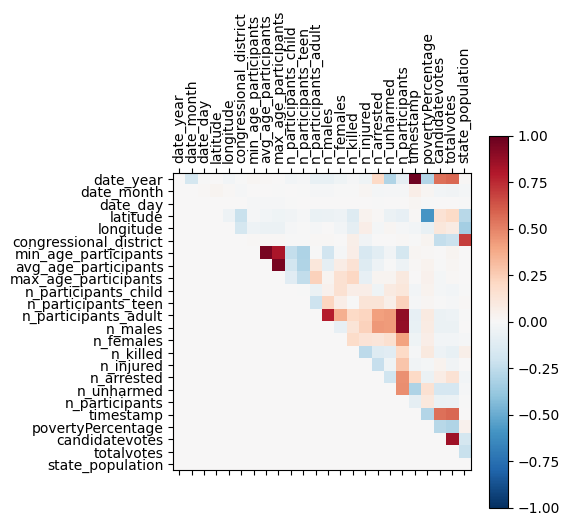

In [21]:
corr = merged.corr(numeric_only=True)
k = 3
triag = np.triu(np.ones(corr.shape), k=1).astype(float)
corr = corr * triag
plt.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

# Augmentation

#### Participants Ratios:

-    p_n_males_ratio: Ratio of the number of males to the total number of participants.
-    p_n_females_ratio: Ratio of the number of females to the total number of participants.
-    p_n_participants_child_ratio: Ratio of the number of child participants to the total number of participants.
-    p_n_participants_teen_ratio: Ratio of the number of teen participants to the total number of participants.
-    p_n_participants_adult_ratio: Ratio of the number of adult participants to the total number of participants.
-    p_n_killed_ratio: Ratio of the number of killed individuals to the total number of participants.
-    p_n_injured_ratio: Ratio of the number of injured individuals to the total number of participants.
-    p_n_arrested_ratio: Ratio of the number of arrested individuals to the total number of participants.
-    p_n_unharmed_ratio: Ratio of the number of unharmed individuals to the total number of participants.

#### Age Deviation:

-    month_cd_change_min_age_participants: Deviation from the minimum age of participants.
-    month_cd_change_avg_age_participants: Deviation from the average age of participants.
-    month_cd_change_max_age_participants: Deviation from the maximum age of participants.

#### Participants Proportions:

-    month_cd_ratio_n_males: Proportion of the number of males among participants in a congressional district and month.
-    month_cd_ratio_n_females: Proportion of the number of females among participants in a congressional district and month.
-    month_cd_ratio_n_participants_child: Proportion of child participants among participants in a congressional district and month.
-    month_cd_ratio_n_participants_teen: Proportion of teen participants among participants in a congressional district and month.
-    month_cd_ratio_n_participants_adult: Proportion of adult participants among participants in a congressional district and month.
-    month_cd_ratio_n_killed: Proportion of killed individuals among participants in a congressional district and month.
-    month_cd_ratio_n_injured: Proportion of injured individuals among participants in a congressional district and month.
-    month_cd_ratio_n_arrested: Proportion of arrested individuals among participants in a congressional district and month.
-    month_cd_ratio_n_unharmed: Proportion of unharmed individuals among participants in a congressional district and month.

#### Incidents Count:

-    month_cd_incidents: Total count of incidents in a congressional district and month.

#### Incidents to Votes Ratio:

-    month_cd_votes_incidents: Ratio of incidents count to the total votes in a congressional district and month.

#### Congressional District Population:

-    cd_population: Estimated population of a congressional district.

#### Party Percentages:

-    percentage_republican: Percentage of votes for the Republican party.
-    percentage_democrat: Percentage of votes for the Democrat party.

#### Incident Characteristics Ratios:

-    For each of the top k most common incident characteristics:
        - cd_month_INCIDENT_NAME_ratio: Ratio of incidents with a specific characteristic to the total incidents in a congressional district and month.
-    cd_month_OTHER: Ratio of incidents with other or less common characteristics to the total incidents in a congressional district and month.

In [22]:
augmented_participants = merged.copy()
PREFIX = lambda c: f'p_{c[2:]}'

participants_cols = ['n_males', 'n_females', 'n_participants_child', 'n_participants_teen', 'n_participants_adult', 'n_killed', 'n_injured', 'n_arrested', 'n_unharmed']

# indicators

for col in participants_cols:
    augmented_participants[PREFIX(col)] = augmented_participants[col] / augmented_participants['n_participants']

augmented_age = augmented_participants.copy()
PREFIX = lambda cs: [f'month_cd_change_{c}' for c in cs]

augmented_age = augmented_age.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
augmented_age = augmented_age.sort_index()

cols = ['min_age_participants', 'avg_age_participants', 'max_age_participants']
mean_val = augmented_age.groupby(augmented_age.index.names)[cols].mean()
augmented_age[PREFIX(cols)] = augmented_age[cols] - mean_val

augmented_age = augmented_age.reset_index()


augmented_p_ratio = augmented_age.copy()
PREFIX = lambda cs: [f'month_cd_ratio_{c[2:]}' for c in cs]

new_params = [p + '_ratio' for p in participants_cols]

augmented_p_ratio = augmented_p_ratio.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
augmented_p_ratio = augmented_p_ratio.sort_index()
sums = augmented_p_ratio.groupby(augmented_p_ratio.index.names)[participants_cols].sum()

augmented_p_ratio[PREFIX(participants_cols)] = augmented_p_ratio[participants_cols].div(sums, axis=0)
augmented_p_ratio = augmented_p_ratio.reset_index()

# Replace NaNs (0/0) with 0
augmented_p_ratio = augmented_p_ratio.fillna(0)


augmented_incidents = augmented_p_ratio.copy()
PREFIX = lambda _: 'month_cd_incidents'

augmented_incidents = augmented_incidents.set_index(['date_year', 'date_month', 'state', 'congressional_district'])
augmented_incidents = augmented_incidents.sort_index()
augmented_incidents['month_cd_incidents'] = augmented_incidents.groupby(augmented_incidents.index.names).size()
augmented_incidents['month_cd_votes_incidents'] = augmented_incidents['month_cd_incidents'] / augmented_incidents['totalvotes']

augmented_incidents = augmented_incidents.reset_index()


augmented_population = augmented_incidents.copy()

votes = state_district_house_eo.copy()
votes = votes[['year', 'state', 'congressional_district', 'totalvotes']]
votes.columns = ['date_year', 'state', 'congressional_district', 'totalvotes']
votes = votes.set_index(['date_year', 'state', 'congressional_district'])
votes = votes.sort_index()

state_votes = votes.groupby(['date_year', 'state']).sum()

augmented_population = augmented_population.set_index(['date_year', 'state', 'congressional_district'])
augmented_population = augmented_population.sort_index()

cd_population = augmented_population['totalvotes'] * augmented_population['state_population'] // state_votes['totalvotes']
cd_population.dropna(inplace=True)

augmented_population['cd_population'] = cd_population

augmented_population = augmented_population.reset_index()

augmented_party = augmented_population.copy()

# a = augmented_party[(augmented_party['party'] != 'REPUBLICAN') * (augmented_party['party'] != 'DEMOCRAT')]

REP_df = augmented_party[augmented_party['party'] == 'REPUBLICAN'].copy()
DEM_df = augmented_party[augmented_party['party'] == 'DEMOCRAT'].copy()
REP_df['percentage_republican'] = REP_df['candidatevotes'] / REP_df['totalvotes']
REP_df['percentage_democrat'] = 1 - (REP_df['candidatevotes'] / REP_df['totalvotes'])
DEM_df['percentage_democrat'] = DEM_df['candidatevotes'] / DEM_df['totalvotes']
DEM_df['percentage_republican'] = 1 - (DEM_df['candidatevotes'] / DEM_df['totalvotes'])
augmented_party = pd.concat([REP_df, DEM_df], ignore_index=True).reset_index(drop=True).sample(frac=1)


import re
regex = re.compile('[^a-zA-Z0-9]')
def rename(s):
    return regex.sub('_', s)

augmented_charateristics = augmented_party.copy()
vc = augmented_charateristics['incident_characteristics1'].value_counts()
most_common = vc.head(k).index.tolist()


augmented_charateristics = augmented_charateristics.set_index(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1'])
augmented_charateristics = augmented_charateristics.sort_index()
something = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district', 'incident_characteristics1']).size()
morething = augmented_charateristics.groupby(['date_year', 'date_month', 'state', 'congressional_district']).size()


# create a column for each of the k most common incident_characteristics1 plus a column for the others
for c in most_common:
    nc = rename(c)
    nc = 'cd_month_' + nc
    perc_state_month = something.xs(c, level='incident_characteristics1') / morething
    perc_state_month.fillna(0, inplace=True)
    augmented_charateristics[nc] = perc_state_month
nc = 'cd_month_OTHER'
perc_state_month = 1 - augmented_charateristics[['cd_month_' + rename(c) for c in most_common]].sum(axis=1)
augmented_charateristics[nc] = perc_state_month

augmented_charateristics = augmented_charateristics.reset_index()

---


### Correlations:
Remove highly correlated columns from the DataFrame augmented_charateristics and visualizes the correlation matrix after the removal.

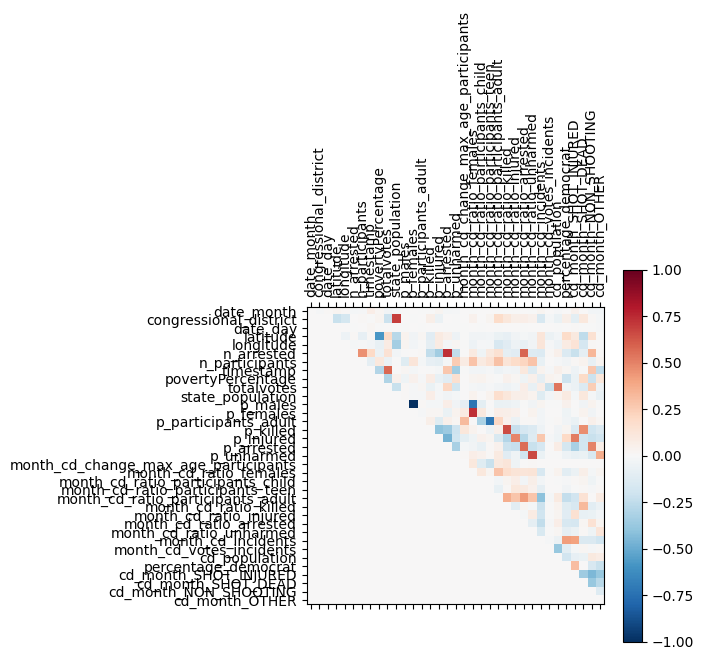

+-------+--------------+--------------------------+--------------+--------------+-------------+---------------+------------------+-------------+---------------------+--------------+--------------------+---------------+---------------+------------------------+---------------+---------------+---------------+---------------+----------------------------------------+--------------------------+-------------------------------------+------------------------------------+-------------------------------------+-------------------------+--------------------------+---------------------------+---------------------------+----------------------+----------------------------+------------------+-----------------------+-------------------------+----------------------+-------------------------+------------------+
|       |   date_month |   congressional_district |     date_day |     latitude |   longitude |    n_arrested |   n_participants |   timestamp |   povertyPercentage |   totalvotes |   state_populat

In [23]:
# Create a copy of the DataFrame
a = augmented_charateristics.copy()

# remove highly correlated columns

# Calculate correlation matrix
corr = a.select_dtypes(include=['float64', 'int64']).corr()

# Set a correlation threshold
threshold = 0.75

# Create an upper triangular matrix with ones
triu = np.triu(np.ones(corr.shape), k=1).astype(int)

corr = corr * triu

# Calculate the absolute correlation values
corr_abs = corr.abs()

# Flatten the correlation matrix and sort the values
s = corr_abs.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

# Filter values based on the threshold
so = so.where((so > threshold) & (so <= 1)).dropna()

# Create a set of columns to remove
to_remove_columns = set()
for i in so.index:
    to_remove_columns.add(i[1])

# Drop the highly correlated columns from the DataFrame
b = a.drop(columns=to_remove_columns)

# Calculate correlation matrix for the modified DataFrame
corr = b.select_dtypes(include=['float64', 'int64']).corr()
triu = np.triu(np.ones(corr.shape), k=1).astype(int)
corr = corr * triu

# Plot the correlation matrix
plt.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1);
plt.colorbar();
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical');
plt.yticks(range(len(corr.columns)), corr.columns);
plt.show();

# Print summary statistics table
print(tabulate(b.describe(), headers='keys', tablefmt='psql'))

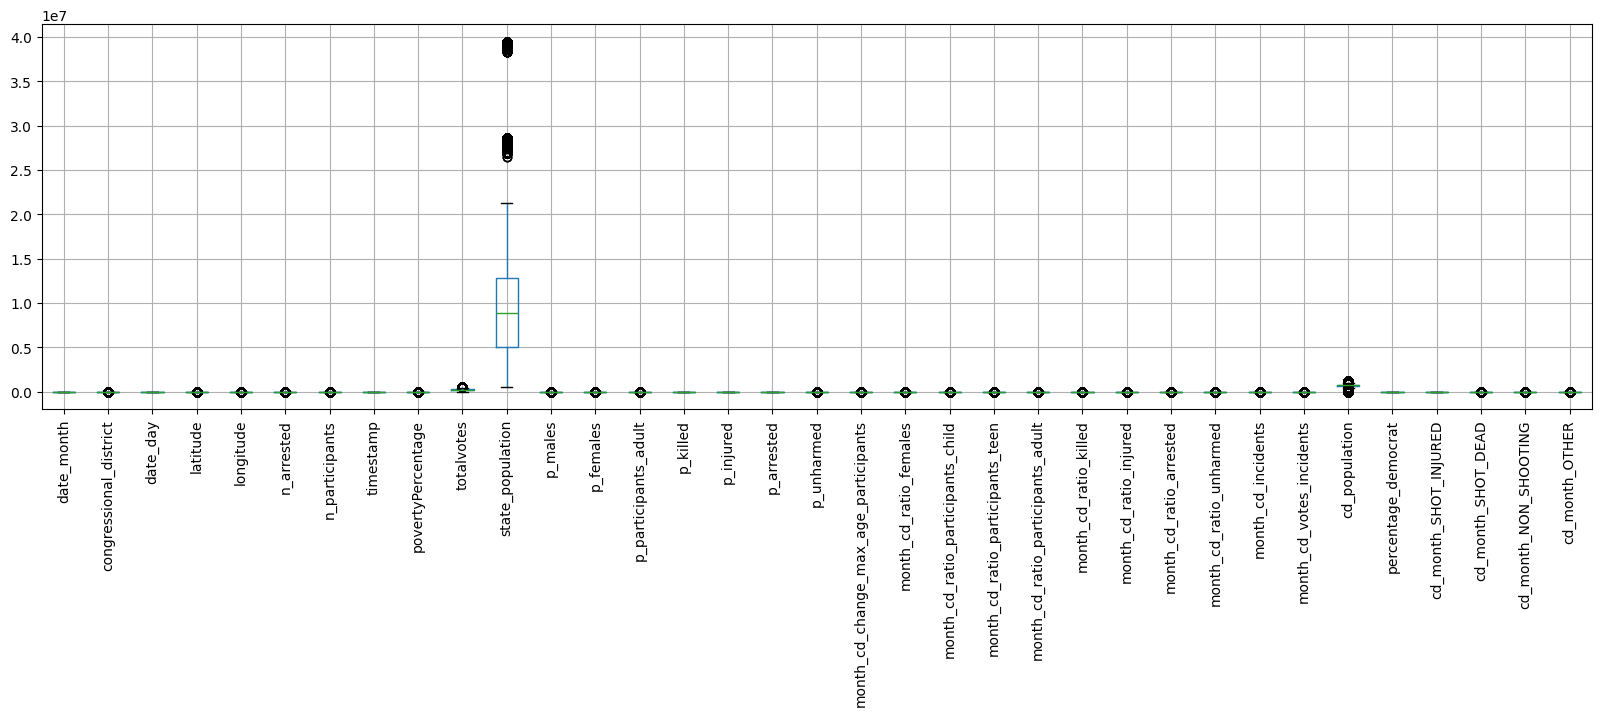

+-------+--------------+--------------------------+--------------+--------------+-------------+---------------+------------------+-------------+---------------------+--------------+--------------------+---------------+---------------+------------------------+---------------+---------------+---------------+---------------+----------------------------------------+--------------------------+-------------------------------------+------------------------------------+-------------------------------------+-------------------------+--------------------------+---------------------------+---------------------------+----------------------+----------------------------+------------------+-----------------------+-------------------------+----------------------+-------------------------+------------------+
|       |   date_month |   congressional_district |     date_day |     latitude |   longitude |    n_arrested |   n_participants |   timestamp |   povertyPercentage |   totalvotes |   state_populat

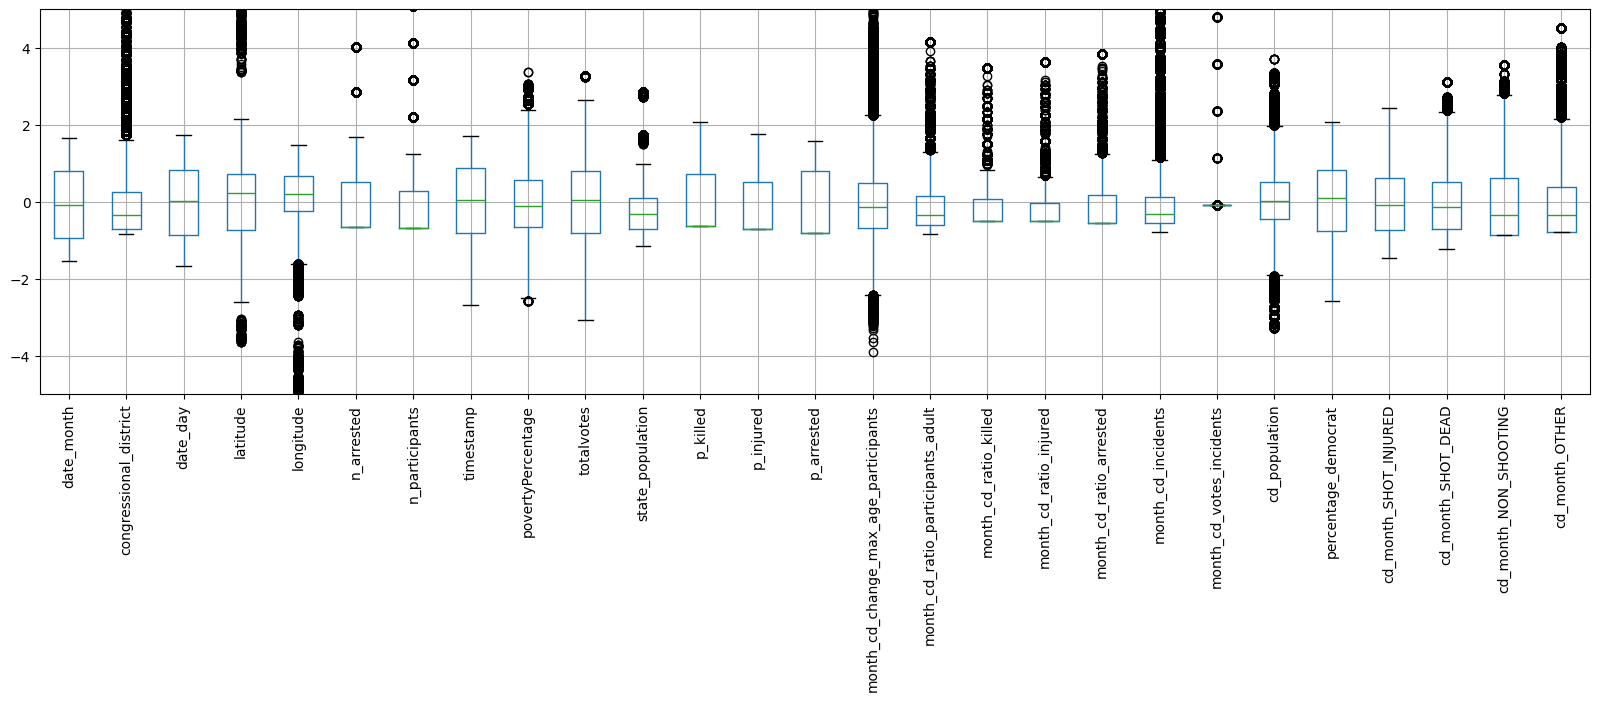

In [28]:
c = b.copy()
# c = c.drop(columns=['state_population'])

# a.hist(bins=30, figsize=(20, 20));
pd.plotting.boxplot(c, figsize=(20, 5));
# rotate axis labels
plt.xticks(rotation=90)
plt.show()

print(tabulate(c.describe(), headers='keys', tablefmt='psql'))

to_remove_columns = []
for col in c.select_dtypes(include=['float64', 'int64']).columns:
    quantiles = c[col].quantile([0.25, 0.75])
    iqr = quantiles[0.75] - quantiles[0.25]
    if iqr == 0:
        to_remove_columns.append(col)

c = c.drop(columns=to_remove_columns)

# ---

from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
d = scaler.fit_transform(c.select_dtypes(include=['float64', 'int64']))
d = pd.DataFrame(d, columns=c.select_dtypes(include=['float64', 'int64']).columns)
d = d.join(c.select_dtypes(exclude=['float64', 'int64']))

import pickle
with open('scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)

pd.plotting.boxplot(d, figsize=(20, 5));
plt.ylim(-5, 5)
plt.xticks(rotation=90)
plt.show()

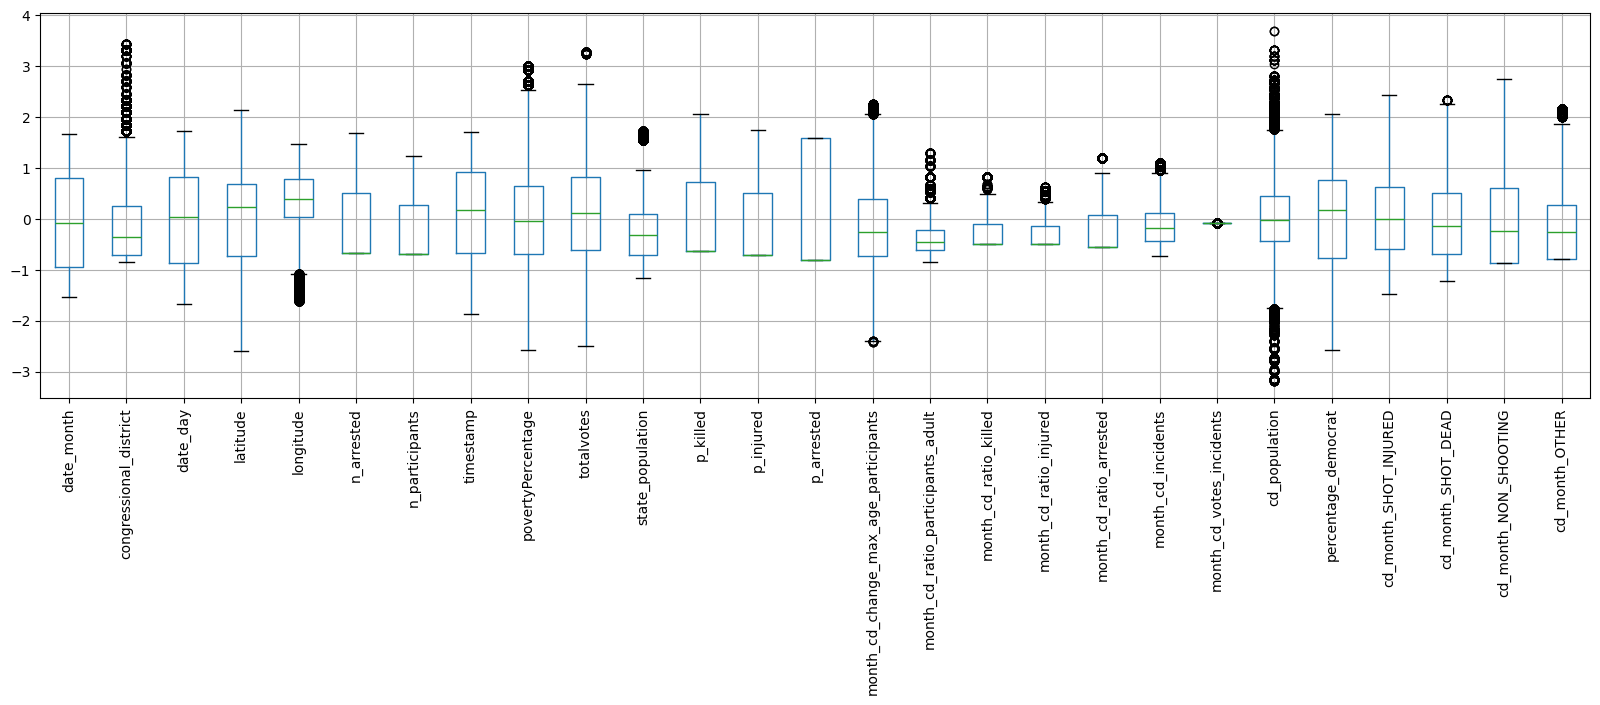

In [29]:
e = d.copy()
f = e.select_dtypes(include=['float64', 'int64']).copy()
to_inter = ['timestamp', 'congressional_district', 'date_month', 'date_day', 'state_population', 'cd_population', 'totalvotes', 'povertyPercentage']
to_inter = list(set(f.columns) & set(to_inter))
f = f.drop(columns=to_inter)

for col in f.columns:
    (q1, q3) = f[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    e = e[(e[col] >= fence_low) * (e[col] <= fence_high)]

pd.plotting.boxplot(e, figsize=(20, 5));
# rotate axis labels
plt.xticks(rotation=90)
plt.show()

---

### Outliers

In [30]:
# Create a copy of the DataFrame for outlier removal
deoutlied = augmented_charateristics.copy()

# Select numeric columns excluding certain non-numeric columns
numeric_cols = deoutlied.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop(['date_year', 'date_month', 'date_day', 'timestamp', 'latitude', 'longitude', 'congressional_district'])

# Iterate through numeric columns to identify and remove outliers using IQR method
for col in numeric_cols:

    # Calculate the first quartile (q1)
    q1 = deoutlied[col].quantile(0.25)

    # Calculate the third quartile (q3)
    q3 = deoutlied[col].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define the lower and upper bounds for outliers using the IQR method
    fence_low  = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr

    # Filter the DataFrame to remove outliers within the specified bounds for the current column
    deoutlied = deoutlied[(deoutlied[col] >= fence_low) * (deoutlied[col] <= fence_high)]

### Correlations

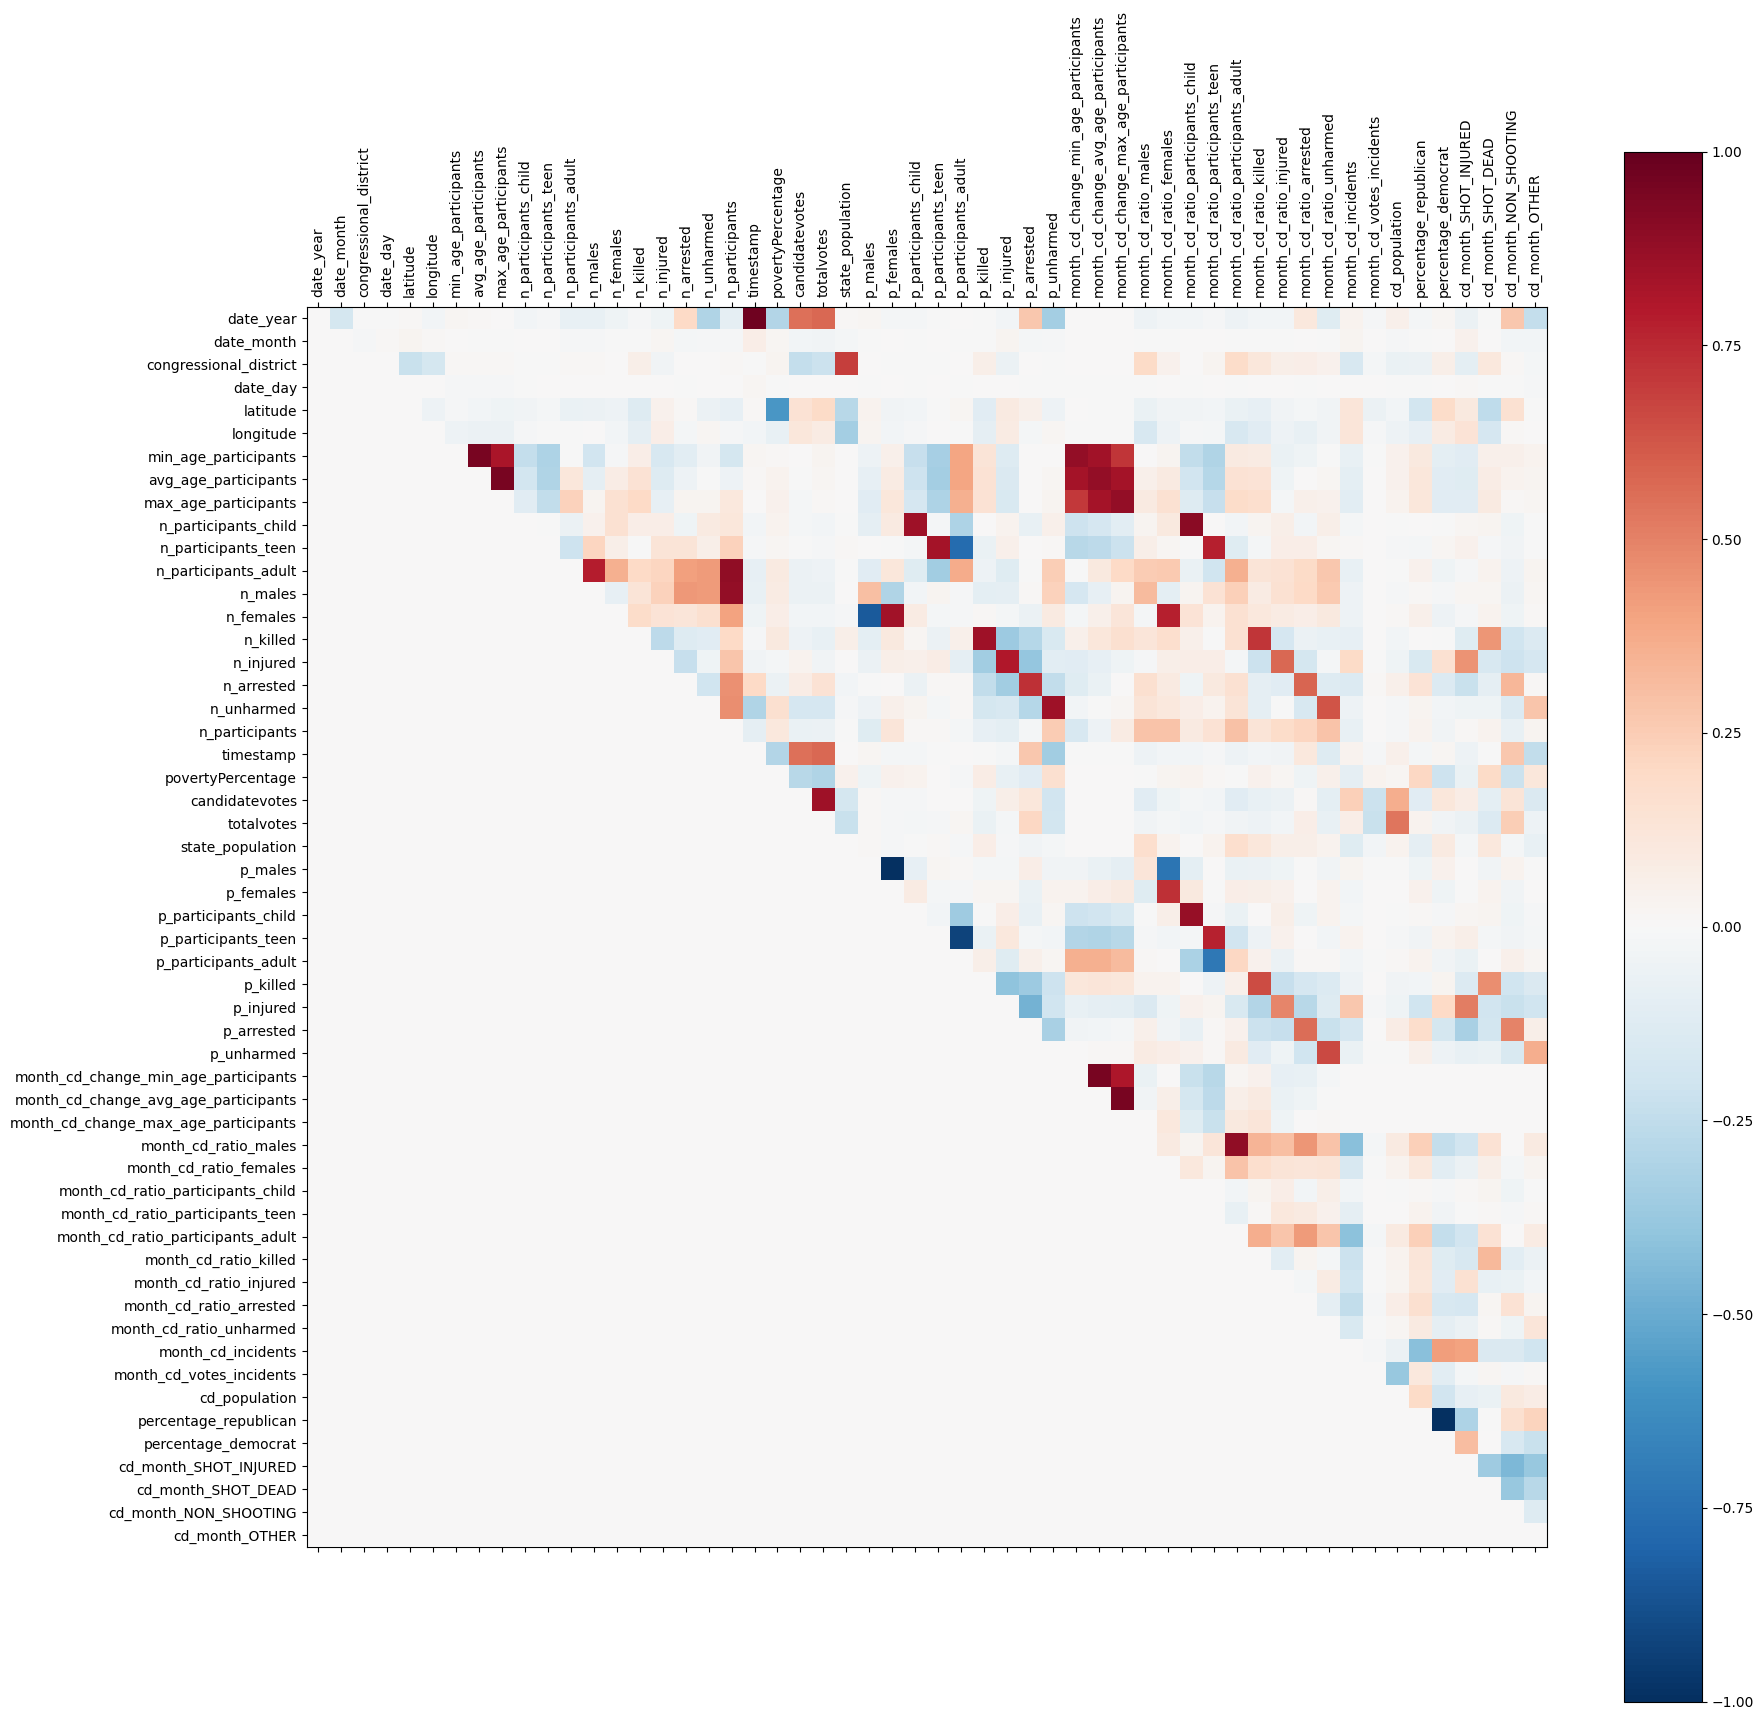

In [31]:
corr = augmented_charateristics.corr(numeric_only=True)
triag = np.triu(np.ones(corr.shape), k=1).astype(float)
corr = corr * triag
plt.figure(figsize=(20,20))
plt.matshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, fignum=1)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

 Identifying and visualizing pairs of columns in the augmented_charateristics DataFrame that have a correlation coefficient of 0.5 or more:

number of plots: 56


/tmp/ipykernel_4381/170521551.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


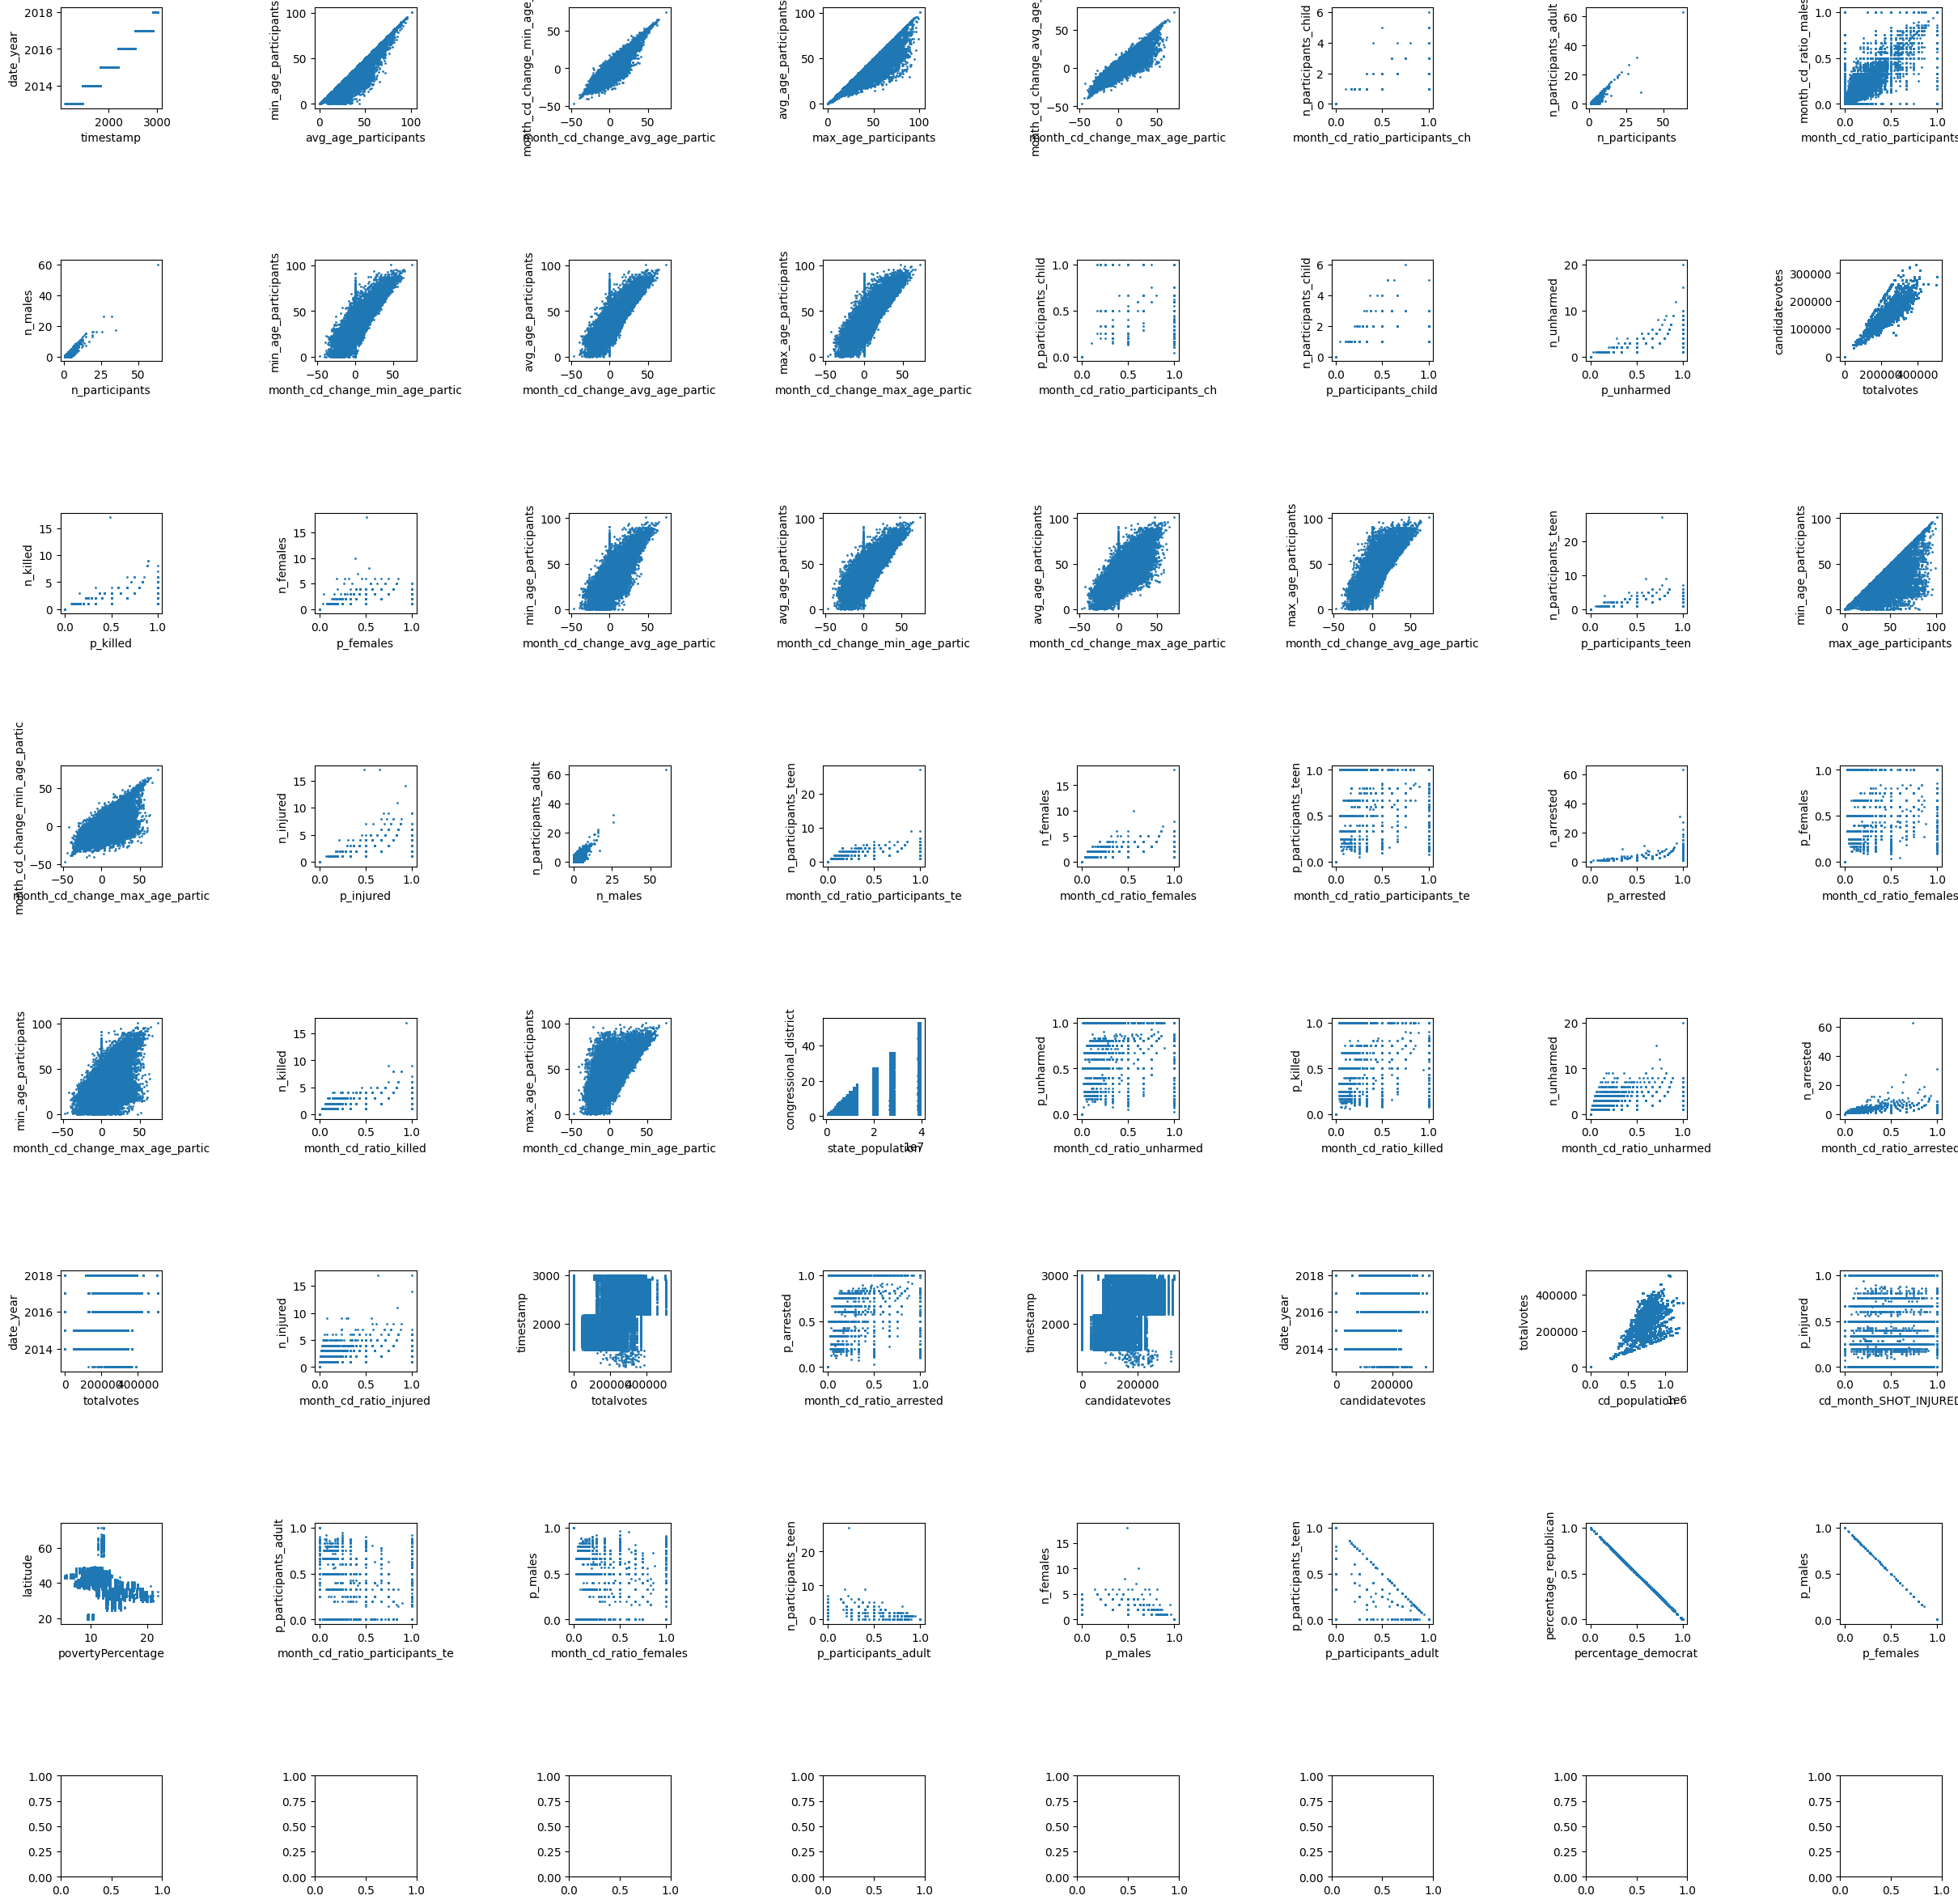

In [32]:
# fetch only corrs that are 0.5 or more
f_corr = corr.where((corr > 0.5) | (corr < -0.5)).dropna(how='all', axis=0).dropna(how='all', axis=1)
f_corr = f_corr.where((corr < 0.9) | (corr > -0.9)).dropna(how='all', axis=0).dropna(how='all', axis=1)
f_corr = f_corr.unstack().dropna().sort_values(kind="quicksort", ascending=False)
print(f"number of plots: {f_corr.shape[0]}")
# scatter plots of the most correlated pairs
fig, axs = plt.subplots(int(np.ceil(np.sqrt(len(f_corr)))), int(np.ceil(np.sqrt(len(f_corr)))), figsize=(30, 30))
# add some space between subplots
fig.subplots_adjust(hspace=1.5, wspace=1.5)
for i, (col1, col2) in enumerate(f_corr.index):
    ax = axs[i // int(np.ceil(np.sqrt(len(f_corr)))), i % int(np.ceil(np.sqrt(len(f_corr))))] if len(f_corr) > 1 else axs
    ax.scatter(augmented_charateristics[col1], augmented_charateristics[col2], s=1)
    ax.set_xlabel(col1[:30])
    ax.set_ylabel(col2[:30])

fig.show()

Histograms for each column in the deoutlied DataFrame:

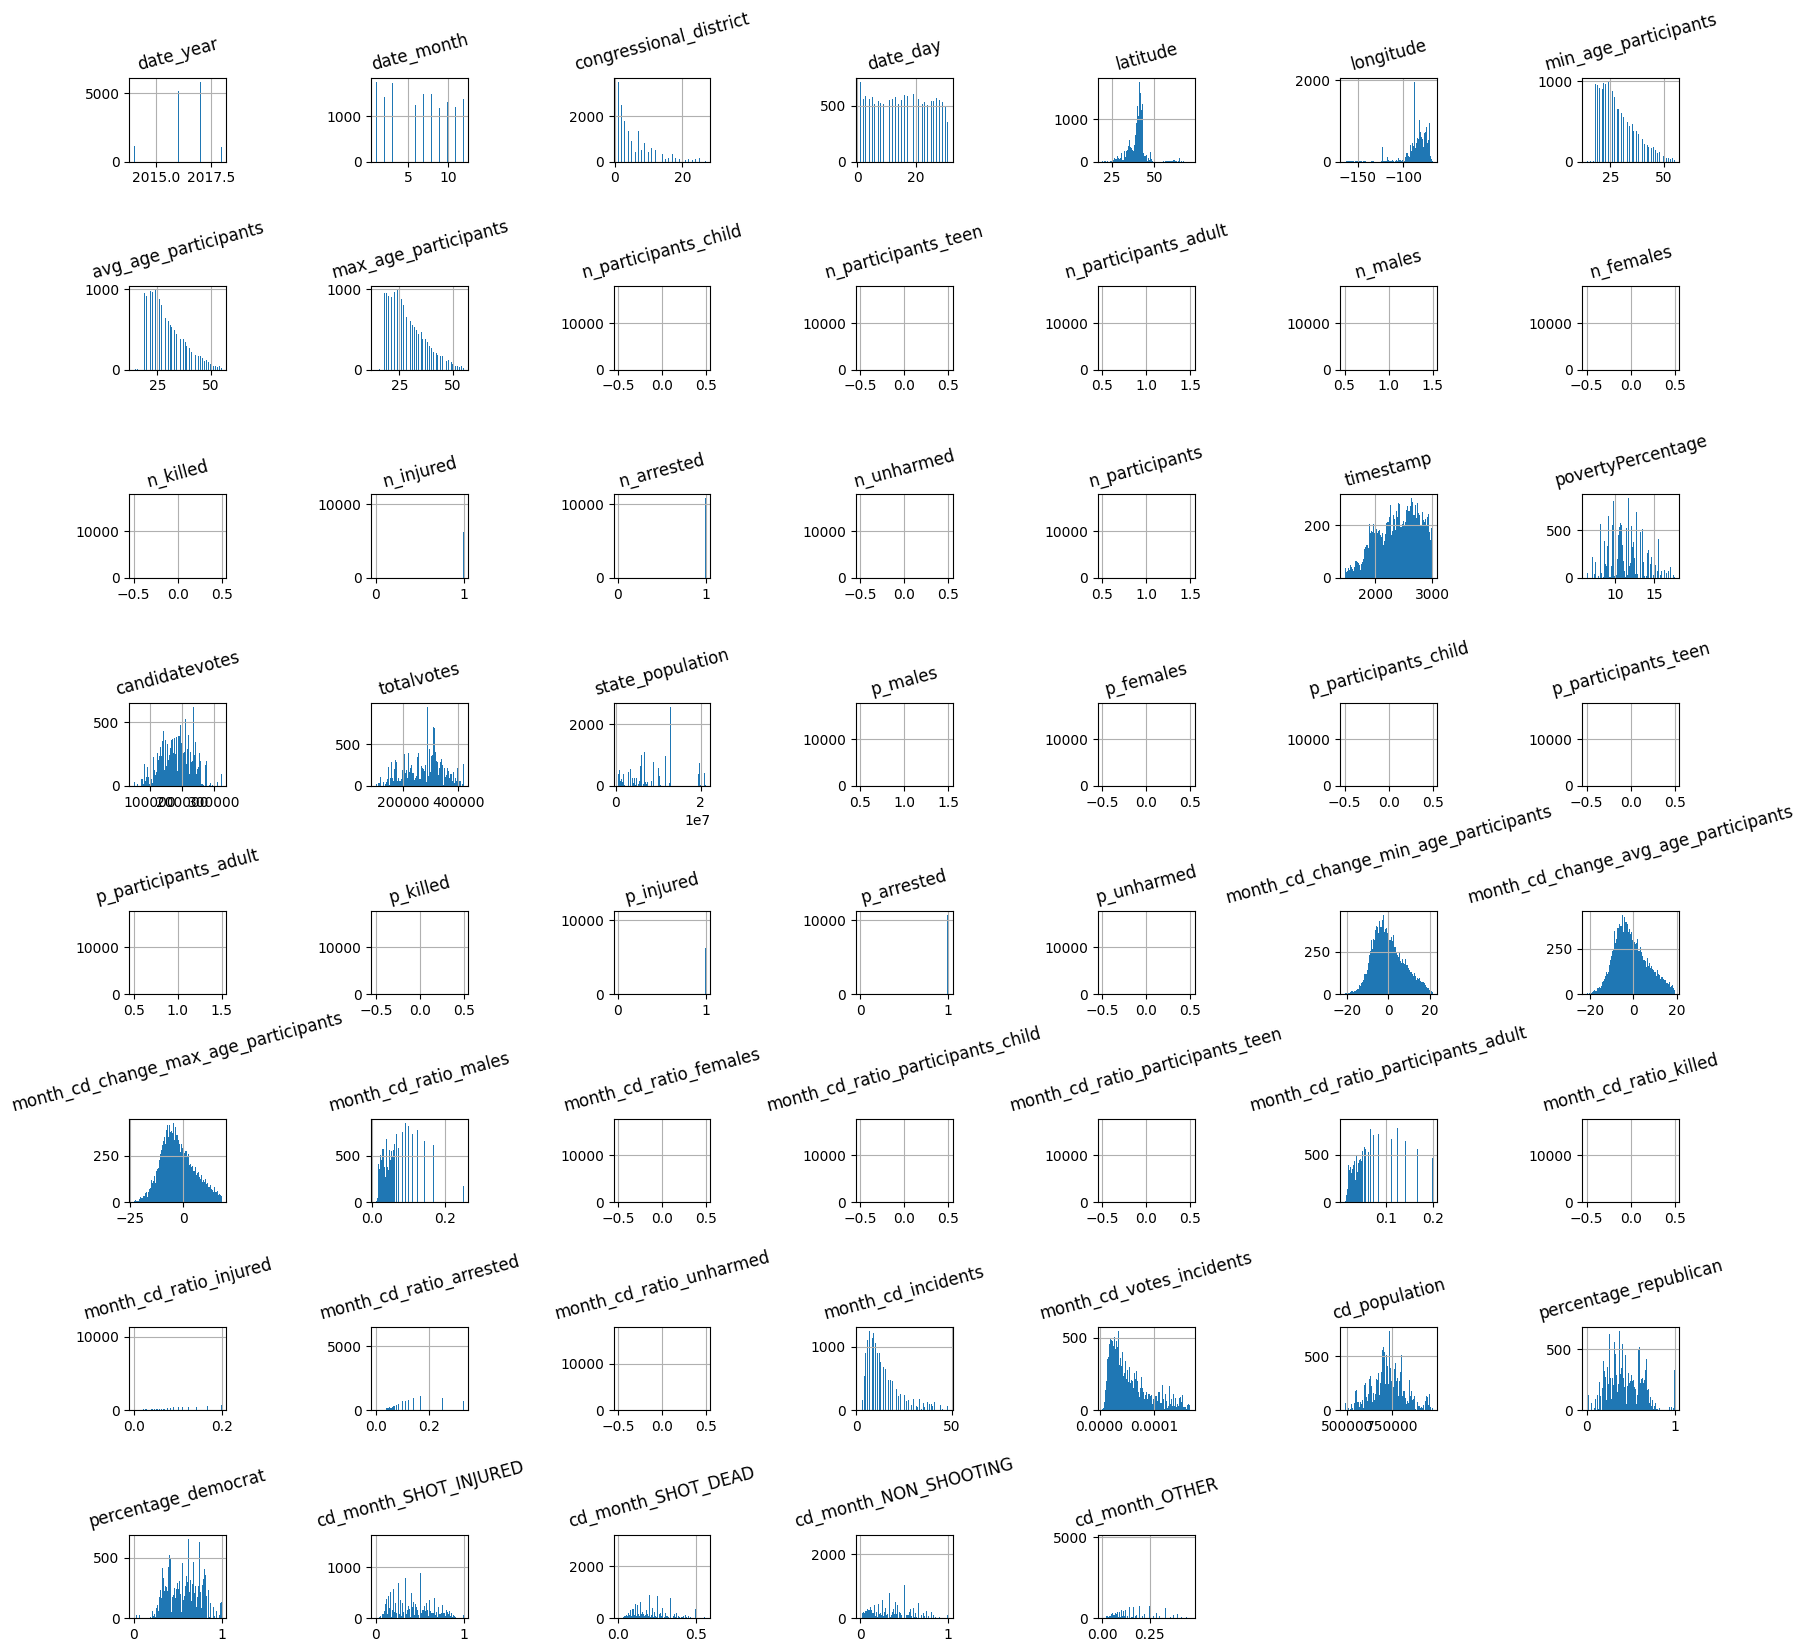

In [33]:
deoutlied.hist(bins=100, figsize=(20, 20));
plt.subplots_adjust(hspace=1.5, wspace=1.5);
# rotate titles
[x.title.set_rotation(15) for x in plt.gcf().axes];

In [34]:
final_clean = e.copy()
import os
os.makedirs('../dataset/data', exist_ok=True)
final_clean.to_csv('../dataset/data/final_clean.csv', index=False)